In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karinaoctaviana","key":"c865bd087a8d570bcfd88e46cbb042bb"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
# Menyalin kaggle.json ke dalam folder yang sudah dibuat
! cp kaggle.json ~/.kaggle/

In [ ]:
# Memberikan izin untuk json bertindak
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d thiagosantosborges/cataracteyeskaggle

 90% 10.0M/11.2M [00:01<00:00, 11.5MB/s]
100% 11.2M/11.2M [00:01<00:00, 7.51MB/s]


In [ ]:
!unzip /content/cataracteyeskaggle.zip

Archive:  /content/cataracteyeskaggle.zip
  inflating: cataract-eyes-kaggle/test/cataract/2018_drauzio_catarata-olho_48967279_arztsamui_outubro_1000x563.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/4ea6b550-95ca-0137-cef9-6231c35b6685--minified.png  
  inflating: cataract-eyes-kaggle/test/cataract/CIRURGIA-DE-PTERGIO.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/Depositphotos_57695057_m-2015.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/Dicas-Prevenir-Catarata.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/Grauer-Star-Senior.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/cat1.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/catarata_1059886916.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/catarata_crianca.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/especialidade-pterigio-iop-2019.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/image10.jpg  
  inflating: cataract-eyes-kaggle/test/cataract/image11.jpg  
  inflating: cata

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import zipfile, os

In [ ]:
train_dir = "/content/cataract-eyes-kaggle/train"
test_dir = "/content/cataract-eyes-kaggle/test"



In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

Found 228 images belonging to 2 classes.
Found 33 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'cataract': 0, 'normal': 1}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)


In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (84, 112, 3)
Image shape: (183, 275, 3)


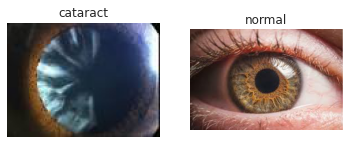

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("/content/cataract-eyes-kaggle/train/", "cataract")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("/content/cataract-eyes-kaggle/train/", "normal")

In [ ]:
# from tensorflow.keras.applications.NASNetMobile import NASNetMobile
vgg19_model = tf.keras.applications.VGG19(input_shape = (224, 224, 3),
                                    weights='imagenet',
                                    include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# from tensorflow.keras.applications.NASNetMobile import NASNetMobile
mobilenet_model = tf.keras.applications.MobileNet(input_shape = (224, 224, 3),
                                    weights='imagenet',
                                    include_top=False)

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
for layer in mobilenet_model.layers:
        layer.trainable = False


x = keras.layers.Flatten()(mobilenet_model.output)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, activation='sigmoid') (x)

modelmobilenet = tf.keras.models.Model(mobilenet_model.input, x)

modelmobilenet.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])
historymobilenet = modelmobilenet.fit(train_generator,
                    epochs = 50,
                    validation_data = validation_generator,
                    callbacks=[earlystop])

Epoch 1/50
8/8 [==============================] - 13s 474ms/step - loss: 5.1332 - accuracy: 0.7193 - val_loss: 3.0765 - val_accuracy: 0.8182
Epoch 2/50
8/8 [==============================] - 3s 410ms/step - loss: 0.3877 - accuracy: 0.9474 - val_loss: 2.4757 - val_accuracy: 0.8182
Epoch 3/50
8/8 [==============================] - 3s 411ms/step - loss: 0.1760 - accuracy: 0.9693 - val_loss: 2.2777 - val_accuracy: 0.8788
Epoch 4/50
8/8 [==============================] - 3s 405ms/step - loss: 0.0687 - accuracy: 0.9868 - val_loss: 2.4244 - val_accuracy: 0.8788
Epoch 5/50
8/8 [==============================] - 3s 403ms/step - loss: 0.1689 - accuracy: 0.9737 - val_loss: 2.5869 - val_accuracy: 0.8788
Epoch 6/50
8/8 [==============================] - 3s 407ms/step - loss: 0.1156 - accuracy: 0.9868 - val_loss: 2.8123 - val_accuracy: 0.9091
Epoch 7/50
8/8 [==============================] - 3s 410ms/step - loss: 0.2354 - accuracy: 0.9737 - val_loss: 2.6518 - val_accuracy: 0.9091
Epoch 8/50
8/8 [===

In [ ]:
modelmobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
for layer in vgg19_model.layers:
        layer.trainable = False


x = keras.layers.Flatten()(vgg19_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

modelVgg19 = tf.keras.models.Model(vgg19_model.input, x)

modelVgg19.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])
historyVgg19 = modelVgg19.fit(train_generator,
                    epochs = 50,
                    validation_data = validation_generator,
                    callbacks=[earlystop])

Epoch 1/50
8/8 [==============================] - 8s 964ms/step - loss: 4.1543 - accuracy: 0.6491 - val_loss: 2.2894 - val_accuracy: 0.6970
Epoch 2/50
8/8 [==============================] - 4s 474ms/step - loss: 0.9630 - accuracy: 0.7982 - val_loss: 1.0505 - val_accuracy: 0.8182
Epoch 3/50
8/8 [==============================] - 4s 477ms/step - loss: 0.8266 - accuracy: 0.8202 - val_loss: 0.4443 - val_accuracy: 0.8788
Epoch 4/50
8/8 [==============================] - 4s 479ms/step - loss: 0.2141 - accuracy: 0.9298 - val_loss: 0.4920 - val_accuracy: 0.8788
Epoch 5/50
8/8 [==============================] - 4s 470ms/step - loss: 0.1142 - accuracy: 0.9605 - val_loss: 0.6481 - val_accuracy: 0.8788
Epoch 6/50
8/8 [==============================] - 4s 480ms/step - loss: 0.1238 - accuracy: 0.9649 - val_loss: 0.6289 - val_accuracy: 0.8788
Epoch 7/50
8/8 [==============================] - 4s 542ms/step - loss: 0.0652 - accuracy: 0.9825 - val_loss: 0.5358 - val_accuracy: 0.9091
Epoch 8/50
8/8 [====

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')


        # create a confusion matrix and a test report
        y_true= np.array(labels)
        y_pred=np.array(y_pred)
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<25:
            if length<8:
                fig_width=8
                fig_height=8
            else:
                fig_width= int(length * .5)
                fig_height= int(length * .5)
            plt.figure(figsize=(fig_width, fig_height))
            sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
            plt.xticks(np.arange(length)+.5, classes, rotation= 90)
            plt.yticks(np.arange(length)+.5, classes, rotation=0)
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix")
            plt.show()
        print("Classification Report:\n----------------------\n", clr)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
preds = modelVgg19.predict(validation_generator)

2/2 [==============================] - 1s 209ms/step


In [ ]:
labels = validation_generator.labels

In [ ]:
y_true = np.array(labels)
y_pred = np.array(preds)
y_pred = y_pred.round()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[14,  3],
       [ 1, 15]])

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_true, y_pred)

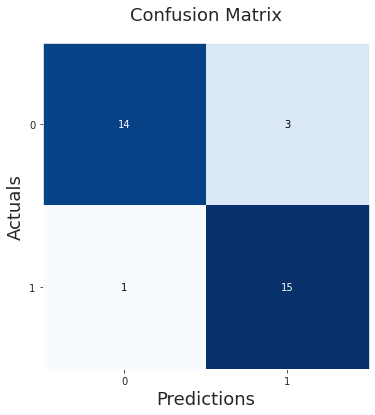

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.83      0.94      0.88        16

    accuracy                           0.88        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.88      0.88      0.88        33



In [ ]:
import tensorflow_hub as hub

In [ ]:
modelmobilenet.save("model_mobilenet.h5")
model = tf.keras.models.load_model(
       ('/content/model_mobilenet.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("CVision_mobileNet.tflite", "wb").write(tflite_model)

38491576

In [ ]:
export_dir ='saved_model/'

In [ ]:
modelVgg19.save("modelVgg19.h5")
model = tf.keras.models.load_model(
       ('/content/modelVgg19.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("CVision_modelVgg19.tflite", "wb").write(tflite_model)

182876912